In [19]:
from torchvision import transforms
from torchvision import datasets
import numpy as np
import PIL
import torch
import torch.nn as nn
import torchvision.datasets as dset

import torch.utils.data
import torchvision


In [20]:
frame_size = (224, 224)

# choose torch device
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'


In [21]:
import custom_resnets
import custom_densenets

# set number of OA grades and dataset directory
n_classes = 5

# choose an architecture
# cnn_model = custom_densenets.se_densenet121_model(n_classes)
cnn_model = custom_resnets.se_resnet18_model(n_classes)

# example loading existing models
# cnn_model.load_state_dict(torch.load('models/SE_DenseNet121_42.ckpt', map_location=torch.device(device)))
cnn_model.load_state_dict(torch.load('models/gamma_2/best_model.ckpt', map_location=torch.device(device)))

# my_target_layer = cnn_model.features.denseblock4[-1]
my_target_layer = cnn_model.layer4[-1]


In [22]:
def forward_hook(module,input,output):
  activation.append(output)

def backward_hook(module,grad_in,grad_out):
  grad.append(grad_out[0])

grad = []
activation = []

# Add hook to get the tensors
my_target_layer.register_forward_hook(forward_hook)
my_target_layer.register_full_backward_hook(backward_hook)

In [23]:
from torchvision import transforms
from PIL import Image

input_image ="dataset/test/4/9814262R.png"
    
single_image = Image.open(input_image).convert("RGB")

transforms_to_test = transforms.Compose([
    transforms.Resize(frame_size), 
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Apply the transformations
single_transformed_image = transforms_to_test(single_image)

# Add an extra dimension to simulate batch size of 1
single_transformed_image = single_transformed_image.unsqueeze(0)

In [24]:
cnn_model.eval()
prediction = cnn_model(single_transformed_image)
predicted_class = torch.argmax(prediction).item()
print("Class = ", predicted_class)

loss = prediction[0, torch.argmax(prediction).item()]
# clear the gradients
cnn_model.zero_grad()

# backward pass to get gradients
loss.backward()

# get the gradients and activations collected in the hook
grads=grad[0].cpu().data.numpy().squeeze()
fmap=activation[0].cpu().data.numpy().squeeze()

Class =  4


In [25]:

print("grads.shape",grads.shape)
tmp=grads.reshape([grads.shape[0],-1])

# Get the mean value of the gradients of every featuremap
weights=np.mean(tmp,axis=1)
print("weights.shape",weights.shape)

grads.shape (512, 7, 7)
weights.shape (512,)


In [26]:
cam = np.zeros(grads.shape[1:])
for i,w in enumerate(weights):
  cam += w*fmap[i,:]
cam=(cam>0)*cam

cam=cam/cam.max()*255


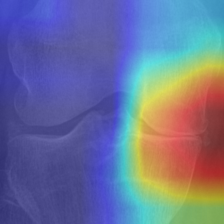

Class =  4
Original Image


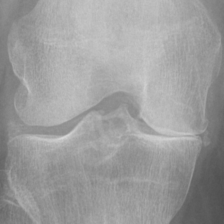

In [27]:
import cv2

pic=cv2.imread(input_image,1)
npic=np.array(torchvision.transforms.ToPILImage()(pic).convert('RGB'))

cam = cv2.resize(cam,(npic.shape[1],npic.shape[0]))

heatmap=cv2.applyColorMap(np.uint8(cam),cv2.COLORMAP_JET)

cam_img=npic*0.5+heatmap*0.5

display(torchvision.transforms.ToPILImage()(np.uint8(cam_img[:,:,::-1])))
print("Class = ", predicted_class)
print("Original Image")
display(torchvision.transforms.ToPILImage()(np.uint8(pic[:,:,::-1])))